In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

22/08/25 15:57:34 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 172.26.239.248 instead (on interface eth0)
22/08/25 15:57:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/25 15:57:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/25 15:57:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=13, titlesize=13)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=13)

# Throughput

In [3]:
THRP_PREFIX = "main/cockroach"

IGNORE_CACHE = False

thrp_index_df = from_cache_or_compute(
    f'{THRP_PREFIX}/index.parquet',
    lambda: get_index(spark, THRP_PREFIX)\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)
thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,100
1,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,50
2,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,100
3,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000000,0
4,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,50
5,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,100
6,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,100000,0
7,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,50
8,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,1000,100
9,file:///home/ctring/data/detock/main/cockroach...,1.0.1029,ddr_ts,60,2000000,3000,0,10,cockroach,100,10,10000,0


## SLOG throughput

In [4]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(thrp_index_df),
    ignore_cache=IGNORE_CACHE,
)

file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot1000000mh100 16552.763709000665
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot1000000mh50 21165.847319652505
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot100000mh100 15557.867289772694
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot1000000mh0 25953.68509941858
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot100000mh50 20169.406925253385
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot10000mh100 15072.193935442996
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot100000mh0 24741.208117487287
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot10000mh50 18113.046369686366
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot1000mh100 14635.01391749053
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot10000mh0 24095.814205019702
file:///home/ctring/data/detock/main/cockroach/ddr_ts-hot1000mh50 16930.198142084533
file:///home/ctring/data/detock/main/cockroach/d

## CockroachDB throughput

In [6]:
crdb_schema = StructType([
    StructField("wl:mh", T.IntegerType(), False),
    StructField("wl:hot", T.IntegerType(), False),
    StructField("region", T.StringType(), False),
    StructField("type", T.StringType(), False),
    StructField("count", T.IntegerType(), False),
    StructField("throughput", T.DoubleType(), False),
    StructField("avg", T.DoubleType(), False),
    StructField("p50", T.DoubleType(), False),
    StructField("p95", T.DoubleType(), False),
    StructField("p99", T.DoubleType(), False),
    StructField("pMax", T.DoubleType(), False),
])

crdb_sdf = spark.read.csv("main/crdb.csv", header=True, schema=crdb_schema)

crdb_df = crdb_sdf\
    .groupBy("wl:mh", "wl:hot")\
    .agg(F.sum("throughput").alias("crdb"))\
    .toPandas()

crdb_df.set_index(["wl:mh", "wl:hot"], inplace=True)
crdb_df.sort_index(inplace=True, ascending=[True, False])

crdb_df.columns = crdb_df.columns.set_names("config_name")
crdb_df

config_name       crdb
wl:mh wl:hot          
0     1000000  14550.2
      100000   14443.1
      10000    13495.2
      1000      1956.3
      100        585.5
      10          90.2
50    1000000  11802.5
      100000   11546.5
      10000     9306.0
      1000       248.3
      100        185.8
      10          39.9
100   1000000  10078.0
      100000    9829.7
      10000     5722.0
      1000       240.5
      100        100.5
      10          24.1

## Plot

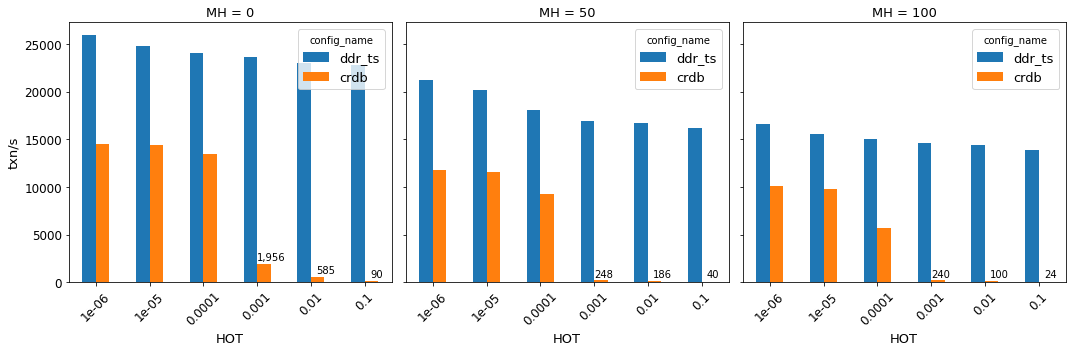

In [7]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = ["wl:mh", "wl:hot"]

pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index(ascending=[True, False])
combined = pivoted.join(crdb_df)

_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

combined.loc[(0, slice(None)), :].plot.bar(ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="txn/s", rot=45)
combined.loc[(50, slice(None)), :].plot.bar(ax=axes[1], title="MH = 50", xlabel="HOT", rot=45)
combined.loc[(100, slice(None)), :].plot.bar(ax=axes[2], title="MH = 100", xlabel="HOT", rot=45)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

def disp(x):
    return f'{x:,.0f}'

HEIGHT = 500
axes[0].annotate(disp(crdb_df.loc[(0, 1000), 'crdb']), (3, HEIGHT + 1800))
axes[0].annotate(disp(crdb_df.loc[(0, 100), 'crdb']), (4.1, HEIGHT + 500))
axes[0].annotate(disp(crdb_df.loc[(0, 10), 'crdb']), (5.1, HEIGHT))
axes[1].annotate(disp(crdb_df.loc[(50, 1000), 'crdb']), (3, HEIGHT + 0.08))
axes[1].annotate(disp(crdb_df.loc[(50, 100), 'crdb']), (4.1, HEIGHT))
axes[1].annotate(disp(crdb_df.loc[(50, 10), 'crdb']), (5.1, HEIGHT))
axes[2].annotate(disp(crdb_df.loc[(100, 1000), 'crdb']), (3, HEIGHT + 0.08))
axes[2].annotate(disp(crdb_df.loc[(100, 100), 'crdb']), (4.1, HEIGHT))
axes[2].annotate(disp(crdb_df.loc[(100, 10), 'crdb']), (5.1, HEIGHT))

plt.tight_layout()

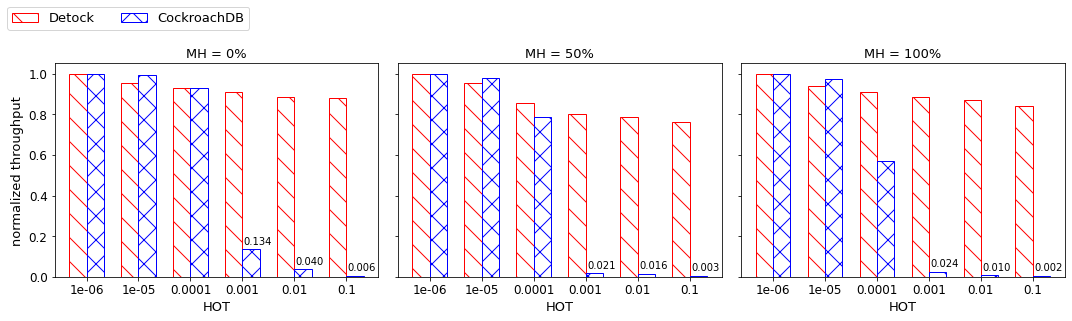

In [8]:
def normalize_per_mh(df):
    mh_pcts = df.index.get_level_values(0).unique()
    for mh_pct in mh_pcts:
        g = df.loc[(mh_pct, slice(None)), :]
        df.loc[(mh_pct, slice(None)), :] /= g.loc[(mh_pct, 1000000), :]
    return df    

crdb_norm_df = normalize_per_mh(crdb_df.copy())
slog_norm_df = normalize_per_mh(pivoted.copy())
combined_norm = slog_norm_df.join(crdb_norm_df)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

xticks = np.array([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])
xticks = xticks.astype('str')
x = np.arange(len(xticks))*1.5

for i, mh in enumerate([0, 50, 100]):
    axes[i].bar(
        x - 0.25,
        combined_norm.loc[(mh, slice(None)), 'ddr_ts'],
        width=0.5,
        fill=False,
        edgecolor='r',
        hatch='\\',
        label='Detock' if i == 0 else '_nolegend_',
    )
    axes[i].bar(
        x + 0.25,
        combined_norm.loc[(mh, slice(None)), 'crdb'],
        width=0.5,
        fill=False,
        edgecolor='b',
        hatch='x',
        label='CockroachDB' if i == 0 else '_nolegend_',
    )
    axes[i].set_title(f'MH = {mh}%')
    axes[i].set_xlabel('HOT')
    if i == 0:
        axes[i].set_ylabel('normalized throughput')

for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)

HEIGHT = 0.03

def disp(x):
    return f'{x:,.3f}'

axes[0].annotate(disp(crdb_norm_df.loc[(0, 1000), 'crdb']), (x[3]+.04, HEIGHT + 0.13))
axes[0].annotate(disp(crdb_norm_df.loc[(0, 100), 'crdb']), (x[4]+.04, HEIGHT + 0.03))
axes[0].annotate(disp(crdb_norm_df.loc[(0, 10), 'crdb']), (x[5]+.04, HEIGHT))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 1000), 'crdb']), (x[3]+.04, HEIGHT + 0.01))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 100), 'crdb']), (x[4]+.04, HEIGHT + 0.01))
axes[1].annotate(disp(crdb_norm_df.loc[(50, 10), 'crdb']), (x[5]+.04, HEIGHT))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 1000), 'crdb']), (x[3]+.04, HEIGHT + 0.02))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 100), 'crdb']), (x[4]+.04, HEIGHT))
axes[2].annotate(disp(crdb_norm_df.loc[(100, 10), 'crdb']), (x[5]+.04, HEIGHT))

fig.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2)
fig.tight_layout()
fig.savefig('output/cockroach-rel-throughput.pdf', bbox_inches='tight')

# Deadlock

In [9]:
crdb_cnt_df = crdb_sdf\
    .withColumn("type", F.regexp_replace("type", "too-old", "other"))\
    .groupBy("wl:mh", "wl:hot", "type")\
    .agg(F.sum("count").alias("count"))\
    .withColumn("pct", 
                100*F.col("count") / F.sum("count").over(
                    Window.partitionBy("wl:mh", "wl:hot")
                )
               )\
    .toPandas()

crdb_cnt_df

,wl:mh,wl:hot,type,count,pct
0,0,10,write,146,1.796923
1,0,10,other,67,0.824615
2,0,10,deadlock,7912,97.378462
3,0,100,write,9047,17.168938
4,0,100,other,1206,2.288686
5,0,100,deadlock,42441,80.542377
6,0,1000,write,157294,89.336060
7,0,1000,deadlock,16423,9.327540
8,0,1000,other,2353,1.336400
9,0,10000,write,1212969,99.863004


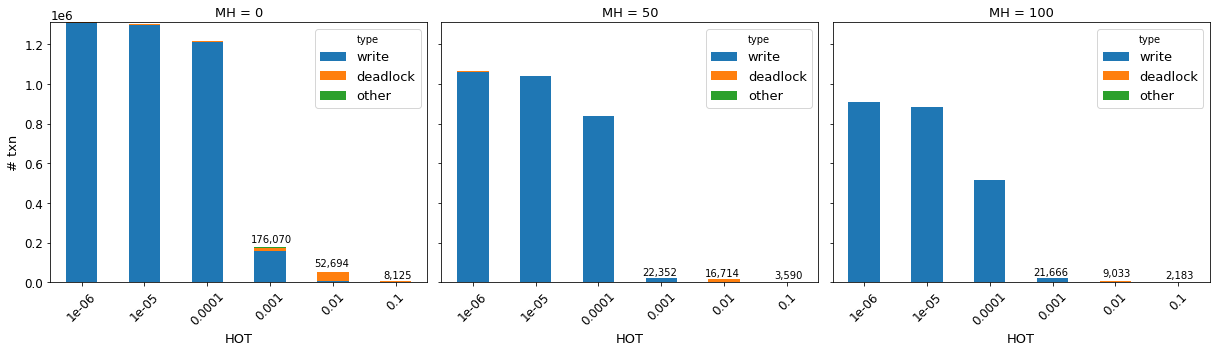

In [10]:
crdb_cnt_pivot_df = crdb_cnt_df.pivot(index=["wl:mh", "wl:hot"], columns="type", values="count")
crdb_cnt_pivot_df.sort_index(inplace=True, ascending=[True, False])
crdb_cnt_pivot_df["sum"] = crdb_cnt_pivot_df["write"] + crdb_cnt_pivot_df['deadlock'] + crdb_cnt_pivot_df['other']

_, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

bars = ['write', 'deadlock', 'other']

crdb_cnt_pivot_df.loc[(0, slice(None)), :].plot.bar(y=bars, ax=axes[0], title="MH = 0", xlabel="HOT", ylabel="# txn", rot=45, stacked=True)
crdb_cnt_pivot_df.loc[(50, slice(None)), :].plot.bar(y=bars, ax=axes[1], title="MH = 50", xlabel="HOT", rot=45, stacked=True)
crdb_cnt_pivot_df.loc[(100, slice(None)), :].plot.bar(y=bars, ax=axes[2], title="MH = 100", xlabel="HOT", rot=45, stacked=True)

for ax in axes:
    ax.set_xticklabels([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])

def disp(x):
    return f'{x:,.0f}'

HEIGHT = 20000

axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 1000), 'sum']), (2.7, HEIGHT + 180000))
axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 100), 'sum']), (3.7, HEIGHT + 60000))
axes[0].annotate(disp(crdb_cnt_pivot_df.loc[(0, 10), 'sum']), (4.8, HEIGHT))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 1000), 'sum']), (2.7, HEIGHT + 15000))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 100), 'sum']), (3.7, HEIGHT + 10000))
axes[1].annotate(disp(crdb_cnt_pivot_df.loc[(50, 10), 'sum']), (4.8, HEIGHT))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 1000), 'sum']), (2.7, HEIGHT + 15000))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 100), 'sum']), (3.8, HEIGHT + 10000))
axes[2].annotate(disp(crdb_cnt_pivot_df.loc[(100, 10), 'sum']), (4.8, HEIGHT))
    
plt.tight_layout()

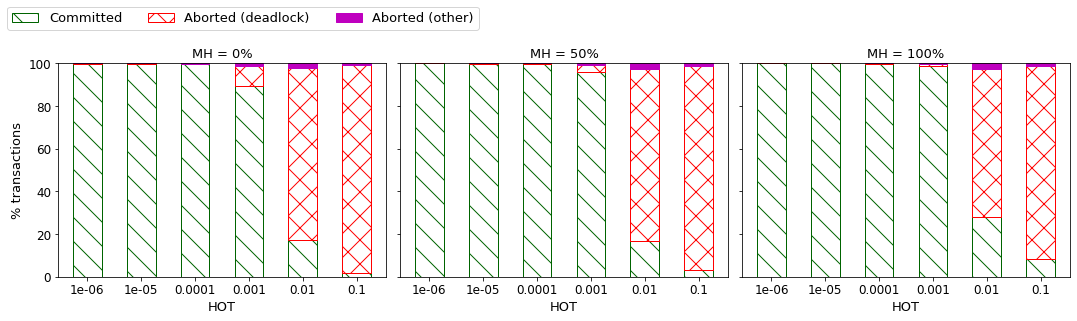

In [11]:
crdb_pct_pivot_df = crdb_cnt_df.pivot(index=["wl:mh", "wl:hot"], columns="type", values="pct")
crdb_pct_pivot_df.sort_index(inplace=True, ascending=[True, False])

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

xticks = np.array([1/1000000, 1/100000, 1/10000, 1/1000, 1/100, 1/10])
xticks = xticks.astype('str')
x = np.arange(len(xticks))*1.5

for i, mh in enumerate([0, 50, 100]):
    write = crdb_pct_pivot_df.loc[(mh, slice(None)), 'write'].to_numpy()
    deadlock = crdb_pct_pivot_df.loc[(mh, slice(None)), 'deadlock'].to_numpy()
    other = crdb_pct_pivot_df.loc[(mh, slice(None)), 'other'].to_numpy()
    axes[i].bar(
        x,
        write,
        fill=False,
        edgecolor='darkgreen',
        hatch='\\',
        label='Committed' if i == 0 else '_nolegend_',
    )
    axes[i].bar(
        x,
        deadlock,
        bottom=write,
        fill=False,
        edgecolor='r',
        hatch='x',
        label='Aborted (deadlock)' if i == 0 else '_nolegend_',
    )
    axes[i].bar(
        x,
        other,
        bottom=write+deadlock,
        # fill=False,
        color='m',
        edgecolor='m',
        # hatch='o',
        label='Aborted (other)' if i == 0 else '_nolegend_',
    )
    axes[i].set_title(f'MH = {mh}%')
    axes[i].set_xlabel('HOT')
    if i == 0:
        axes[i].set_ylabel('% transactions')

for ax in axes:
    ax.set_ylim((0, 100))
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)

fig.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=3)
fig.tight_layout()
fig.savefig('output/cockroach-pct-abort.pdf', bbox_inches='tight')

# Latency

In [12]:
LAT_PREFIX = "main/cockroach-latency"

IGNORE_CACHE = False

lat_index_df = from_cache_or_compute(
    f'{LAT_PREFIX}/index.parquet',
    lambda: get_index(spark, LAT_PREFIX)\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)
lat_index_df

Saved to: main/cockroach-latency/index.parquet


,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000000,100
1,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000000,50
2,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100000,100
3,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000000,0
4,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100000,50
5,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,100
6,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100000,0
7,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,50
8,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000,100
9,file:/home/ctring/data/detock/main/cockroach-l...,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,0


In [13]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

slog_latency_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency.parquet',
    lambda: latency(spark, lat_index_df["prefix"])\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)
slog_latency_df

Saved to: main/cockroach-latency/latency.parquet


,prefix,p50,p95,p99,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:value_size,wl:records,wl:hot,wl:mh
0,file:/home/ctring/data/detock/main/cockroach-l...,15.433728,146.270464,155.821824,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,50
1,file:/home/ctring/data/detock/main/cockroach-l...,9.134848,10.404352,11.230208,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10,0
2,file:/home/ctring/data/detock/main/cockroach-l...,77.787136,152.648192,156.900864,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000000,100
3,file:/home/ctring/data/detock/main/cockroach-l...,9.147648,10.247168,11.150848,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100,0
4,file:/home/ctring/data/detock/main/cockroach-l...,9.227008,10.298880,11.403520,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000000,0
5,file:/home/ctring/data/detock/main/cockroach-l...,77.483520,157.654784,161.422592,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100,100
6,file:/home/ctring/data/detock/main/cockroach-l...,9.202944,10.479360,11.810304,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,0
7,file:/home/ctring/data/detock/main/cockroach-l...,28.395264,147.511296,160.313088,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,100,50
8,file:/home/ctring/data/detock/main/cockroach-l...,77.205504,158.718976,164.083968,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,10000,100
9,file:/home/ctring/data/detock/main/cockroach-l...,18.908672,147.747328,160.525824,1.0.1029,ddr_ts,30,2000000,16,0,10,cockroach,100,10,1000,50


In [15]:
crdb_schema = StructType([
    StructField("wl:mh", T.IntegerType(), False),
    StructField("wl:hot", T.IntegerType(), False),
    StructField("region", T.StringType(), False),
    StructField("throughput", T.DoubleType(), False),
    StructField("avg", T.DoubleType(), False),
    StructField("p50", T.DoubleType(), False),
    StructField("p95", T.DoubleType(), False),
    StructField("p99", T.DoubleType(), False),
    StructField("pMax", T.DoubleType(), False),
])
crdb_latency_df = spark.read.csv("main/crdb-latency.csv", header=True, schema=crdb_schema)\
    .groupBy("wl:mh", "wl:hot")\
    .agg(
        F.avg("p50").alias("p50"),
        F.avg("p95").alias("p95"),
        F.avg("p99").alias("p99"),
    )\
    .toPandas()

crdb_latency_df["config_name"] = "crdb"
crdb_latency_df

,wl:mh,wl:hot,p50,p95,p99,config_name
0,100,10000,805.316667,1437.250000,1448.433333,crdb
1,50,10,4982.850000,42054.900000,47602.550000,crdb
2,50,100,648.733333,2304.050000,3892.283333,crdb
3,0,1000000,20.100000,26.933333,29.900000,crdb
4,0,10,788.550000,3735.716667,5905.600000,crdb
5,100,1000000,810.916667,1437.250000,1470.800000,crdb
6,100,1000,805.316667,1448.433333,2046.816667,crdb
7,50,1000000,86.866667,1437.250000,1515.533333,crdb
8,0,100000,20.633333,27.266667,30.083333,crdb
9,0,1000,20.433333,27.283333,39.466667,crdb


In [16]:
def plot_latency(df, yscale='log'):
    _, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True)

    configs = df["config_name"].unique()
    mh_pcts = sorted(df["wl:mh"].unique())
    
    colors = ['C0', 'C1']

    for i, config in enumerate(configs):
        for r, mh_pct in enumerate(mh_pcts):
            mask = (df["config_name"] == config) & (df["wl:mh"] == mh_pct)
            filtered = df[mask].sort_values("wl:hot", ascending=False)
            label = config.replace('.conf', '')

            filtered.plot(ax=axes[r], x="wl:hot", y="p50", label=f'{label}_50', linestyle='dotted', marker='.', color=colors[i])
            filtered.plot(ax=axes[r], x="wl:hot", y="p95", label=f'{label}_95', linestyle='dashed', marker='.', color=colors[i])
            filtered.plot(ax=axes[r], x="wl:hot", y="p99", label=f'{label}_99', marker='.', color=colors[i])

            axes[r].set_title(f"MH_PCT = {mh_pct}")
            axes[r].set_ylabel("latency (ms)")
            axes[r].set_xlabel("HOT")
            axes[r].grid(axis='y')
            axes[r].set_yscale(yscale)
            axes[r].set_xscale('log')
            if r != 0:
                axes[r].legend([])

    plt.tight_layout()

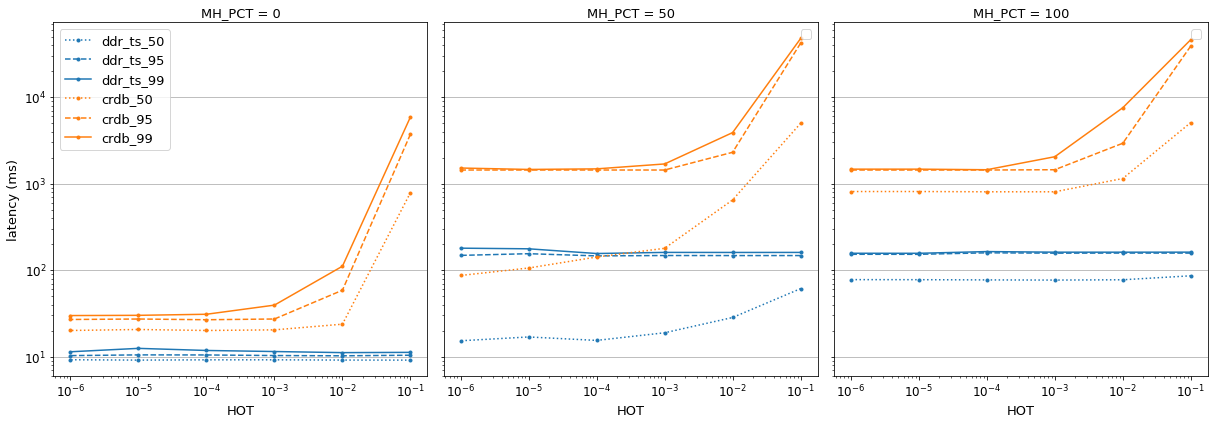

In [17]:
latency_df = pd.concat([slog_latency_df, crdb_latency_df])
latency_df.loc[:, "wl:hot"] = 1 / latency_df.loc[:, "wl:hot"]
plot_latency(latency_df)